# Generating Weekday and Weekend profiles

In [2]:
import polars as pl
import glob
import numpy as np
import matplotlib.pyplot as plt
import logging
from tslearn.clustering import TimeSeriesKMeans 

logging.getLogger('matplotlib.font_manager').disabled = True

from validation import validation

from kmodes.kprototypes import KPrototypes

import pandas as pd

In [5]:
pattern = f"{"/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/SM_DATA_hourlyAveraged_normalized"}/*CH*.csv"
file_paths = glob.glob(pattern)

In [6]:
n_timestamps = 96

data_list = []

for idx, file_path in enumerate(file_paths):
    df = pl.read_csv(file_path)
    
    if len(df) == n_timestamps:
        values_array = df["day_avg_bruttolastgang_kwh"].to_numpy().reshape((1, n_timestamps, 1))
        data_list.append(values_array)

data_3d = np.concatenate(data_list, axis=0)
print(f"Shape of the 3D array: {data_3d.shape}")

train_data = data_3d

n_samples = data_3d.shape[0]




Shape of the 3D array: (1464, 96, 1)


In [7]:
# Read the Excel file

# missing vlaues are encoded as -1

file_path = "/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/Survey_Data/Survey_Data.xlsx"

# 1. Read the survey data
survey_df = pd.read_excel(file_path, skiprows=4, nrows=n_samples, header=None)

# Columns to extract as survey features: heat pump, EV, electrical heating of hot water
cols_to_extract = [144, 145, 146, 131, 128, 129]

# First, create the categorical objects for each survey column
cat1 = survey_df.iloc[:, cols_to_extract[0]].astype('category')
cat2 = survey_df.iloc[:, cols_to_extract[1]].astype('category')
cat3 = survey_df.iloc[:, cols_to_extract[2]].astype('category')
cat4 = survey_df.iloc[:, cols_to_extract[3]].astype('category')
cat5 = survey_df.iloc[:, cols_to_extract[4]].astype('category')
cat6 = survey_df.iloc[:, cols_to_extract[5]].astype('category')

# You already have the integer codes stored in these arrays:
survey_array1 = cat1.cat.codes.to_numpy()
survey_array2 = cat2.cat.codes.to_numpy()
survey_array3 = cat3.cat.codes.to_numpy()
survey_array4 = cat4.cat.codes.to_numpy()
survey_array5 = cat5.cat.codes.to_numpy()
survey_array6 = cat6.cat.codes.to_numpy()

# Number of samples and timestamps in your existing data_3d
n_samples, n_timestamps, n_features = data_3d.shape

# Check length consistency
assert len(survey_array1) == n_samples
assert len(survey_array2) == n_samples
assert len(survey_array3) == n_samples
assert len(survey_array4) == n_samples
assert len(survey_array5) == n_samples
assert len(survey_array6) == n_samples

# 2. Flatten the numeric time series part (assuming original consumption feature is index 0)
time_series_numeric = data_3d[:, :, 0].reshape(n_samples, n_timestamps)

# 3. Stack survey arrays to shape (n_samples, 3) as categorical features
survey_features = np.stack([survey_array1, survey_array2, survey_array3, survey_array4, survey_array5, survey_array6], axis=1)

# 4. Combine numeric + categorical features horizontally
combined_data = np.hstack([time_series_numeric, survey_features])

print(combined_data[:5, -5:])  # Print first 5 rows of the last 3 columns (survey features)




[[ 0.  0.  2.  2.  2.]
 [ 0.  0. -1. -1. -1.]
 [ 0.  0.  2.  2.  2.]
 [ 0.  1. -1. -1. -1.]
 [ 0.  0.  2.  1.  2.]]


In [8]:

# combined_data shape: (n_samples, n_timestamps + 4)

# Create mask: True for rows with no -1 in the last 4 columns
valid_rows_mask = ~np.any(combined_data == -1, axis=1)

# Filter combined_data to keep only valid rows
combined_data_filtered = combined_data[valid_rows_mask]

print(f"Original number of samples: {combined_data.shape[0]}")
print(f"Filtered number of samples (no -1 in survey features): {combined_data_filtered.shape[0]}")

print(combined_data_filtered[:5, -4:])  # Check first 5 filtered rows for survey features

Original number of samples: 1464
Filtered number of samples (no -1 in survey features): 1253
[[0. 2. 2. 2.]
 [0. 2. 2. 2.]
 [0. 2. 1. 2.]
 [0. 2. 2. 2.]
 [0. 2. 0. 2.]]


In [15]:


# 5. Specify the categorical feature column indices (the last 3 columns)
categorical_indices = list(range(combined_data.shape[1] - 3, combined_data.shape[1]))

# 6. Initialize and run K-Prototypes clustering
kproto = KPrototypes(
    n_clusters=6, 
    init='Cao', 
    verbose=0, 
    max_iter=200, 
    gamma=0.5,
    random_state=42,
    n_init=10
)

clusters = kproto.fit_predict(combined_data, categorical=categorical_indices)

clusters = clusters + 1

print("Cluster labels:")
print(clusters)

Cluster labels:
[6 6 4 ... 6 5 5]


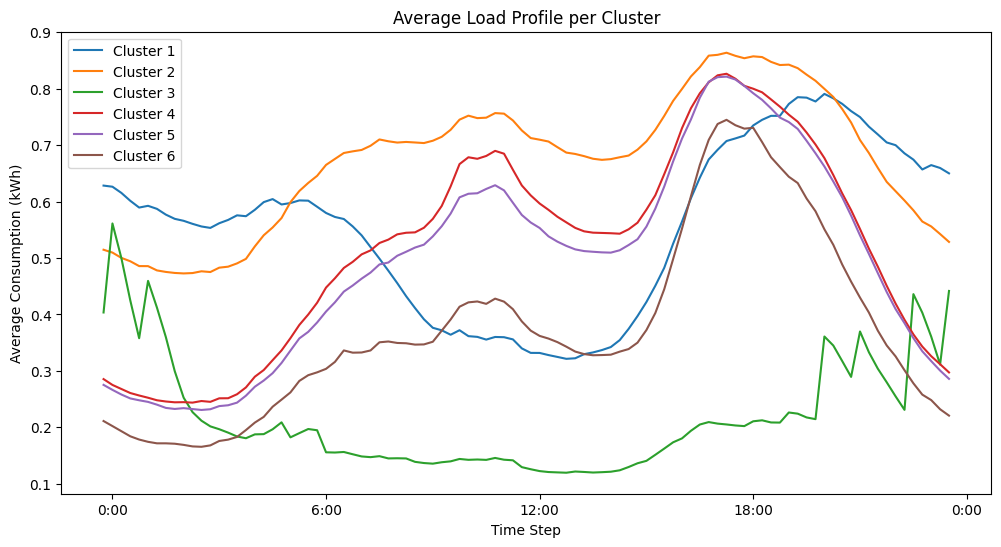

In [16]:
unique_clusters = np.unique(clusters)

labels = ['0:00','6:00','12:00','18:00','0:00']

plt.figure(figsize=(12, 6))
for cl in unique_clusters:
    idx = np.where(clusters == cl)[0]
    avg_profile = time_series_numeric[idx].mean(axis=0)
    plt.plot(avg_profile, label=f'Cluster {cl}')

plt.title('Average Load Profile per Cluster')
plt.xticks(range(1,120,24),labels=labels)
plt.xlabel('Time Step')
plt.ylabel('Average Consumption (kWh)')
plt.legend()
plt.show()



In [17]:
df = pd.DataFrame({
    'cluster': clusters,
    'HP': survey_array1,                  # 0/1 integer (e.g., "Has Heat Pump")
    'EV': survey_array2,                  # 0/1 integer (e.g., "Has EV")
    'Electric Water Heating': survey_array3,  # 0/1 integer
    'Tenant Type': survey_array4,
    'Monthly Income_decoded': survey_array5,
    'Education_decoded' : survey_array6
})

def decode_codes_with_na(codes, categories, na_label="NaN"):
    decoded = np.full(codes.shape, na_label, dtype=object)
    valid_mask = codes >= 0
    decoded[valid_mask] = categories[codes[valid_mask]]
    return decoded

# Example usage for Tenant Type
df['Tenant Type_decoded'] = decode_codes_with_na(df['Tenant Type'], cat4.cat.categories, na_label="NaN")

# Similarly decode others if needed
df['HP_decoded'] = decode_codes_with_na(df['HP'], cat1.cat.categories, na_label="NaN")
df['EV_decoded'] = decode_codes_with_na(df['EV'], cat2.cat.categories, na_label="NaN")
df['Electric Water Heating_decoded'] = decode_codes_with_na(df['Electric Water Heating'], cat3.cat.categories, na_label="NaN")
df['Monthly Income_decoded'] = decode_codes_with_na(df['Monthly Income_decoded'], cat5.cat.categories, na_label="NaN")
df['Education_decoded'] = decode_codes_with_na(df['Education_decoded'], cat6.cat.categories, na_label="NaN")

#print(df)




In [18]:
# Columns to check for 'NaN' string
decoded_cols = ['HP_decoded', 'EV_decoded', 'Electric Water Heating_decoded', 'Tenant Type_decoded', 'Monthly Income_decoded', 'Education_decoded']

# Filter out rows where any decoded column has 'NaN'
df_cleaned = df[~df[decoded_cols].isin(['NaN']).any(axis=1)]


print(f'Available households with available survey data: {len(df_cleaned)} out of {len(df)}')

Available households with available survey data: 1253 out of 1464


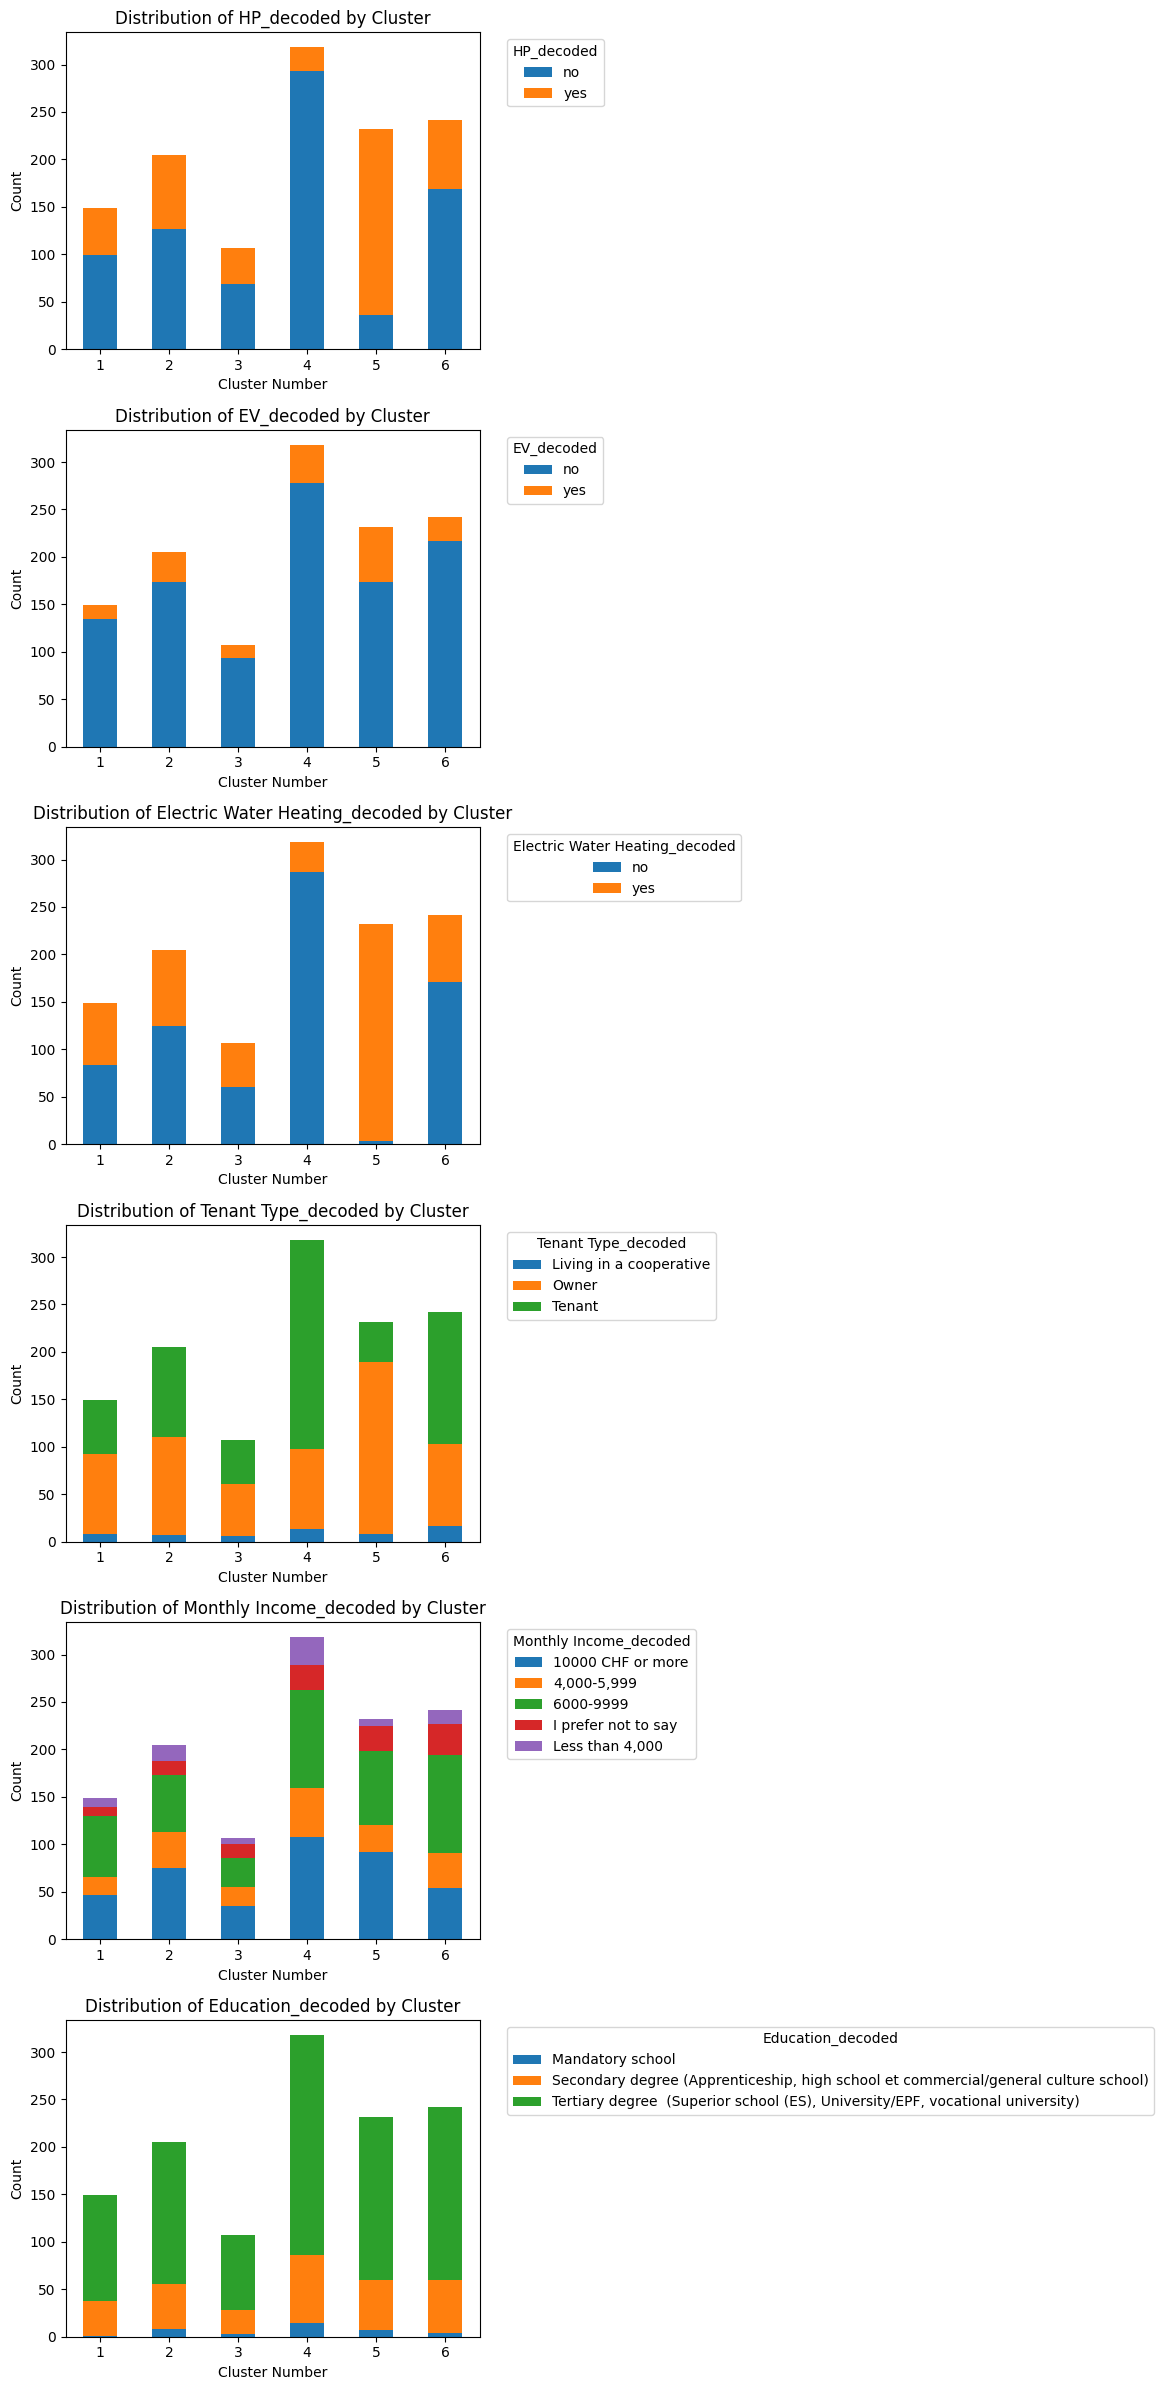

In [19]:
cat_columns = ['HP_decoded', 'EV_decoded', 'Electric Water Heating_decoded', 'Tenant Type_decoded', 'Monthly Income_decoded', 'Education_decoded']
n_features = len(cat_columns)

fig, axes = plt.subplots(n_features, 1, figsize=(12, 4 * n_features))

for i, feature in enumerate(cat_columns):
    ax = axes[i]
    
    # Group and pivot data for the plot
    counts = df_cleaned.groupby(['cluster', feature]).size().unstack(fill_value=0)
    
    # Plot stacked bar chart
    counts.plot(kind='bar', stacked=True, ax=ax)
    
    # Titles and axis labels
    ax.set_title(f'Distribution of {feature} by Cluster')
    ax.set_ylabel('Count')
    ax.set_xlabel('Cluster Number')
    
    # Rotate x-axis tick labels by 90 degrees
    ax.set_xticklabels(ax.get_xticklabels(), rotation=-0)
    ax.legend(title=feature, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()







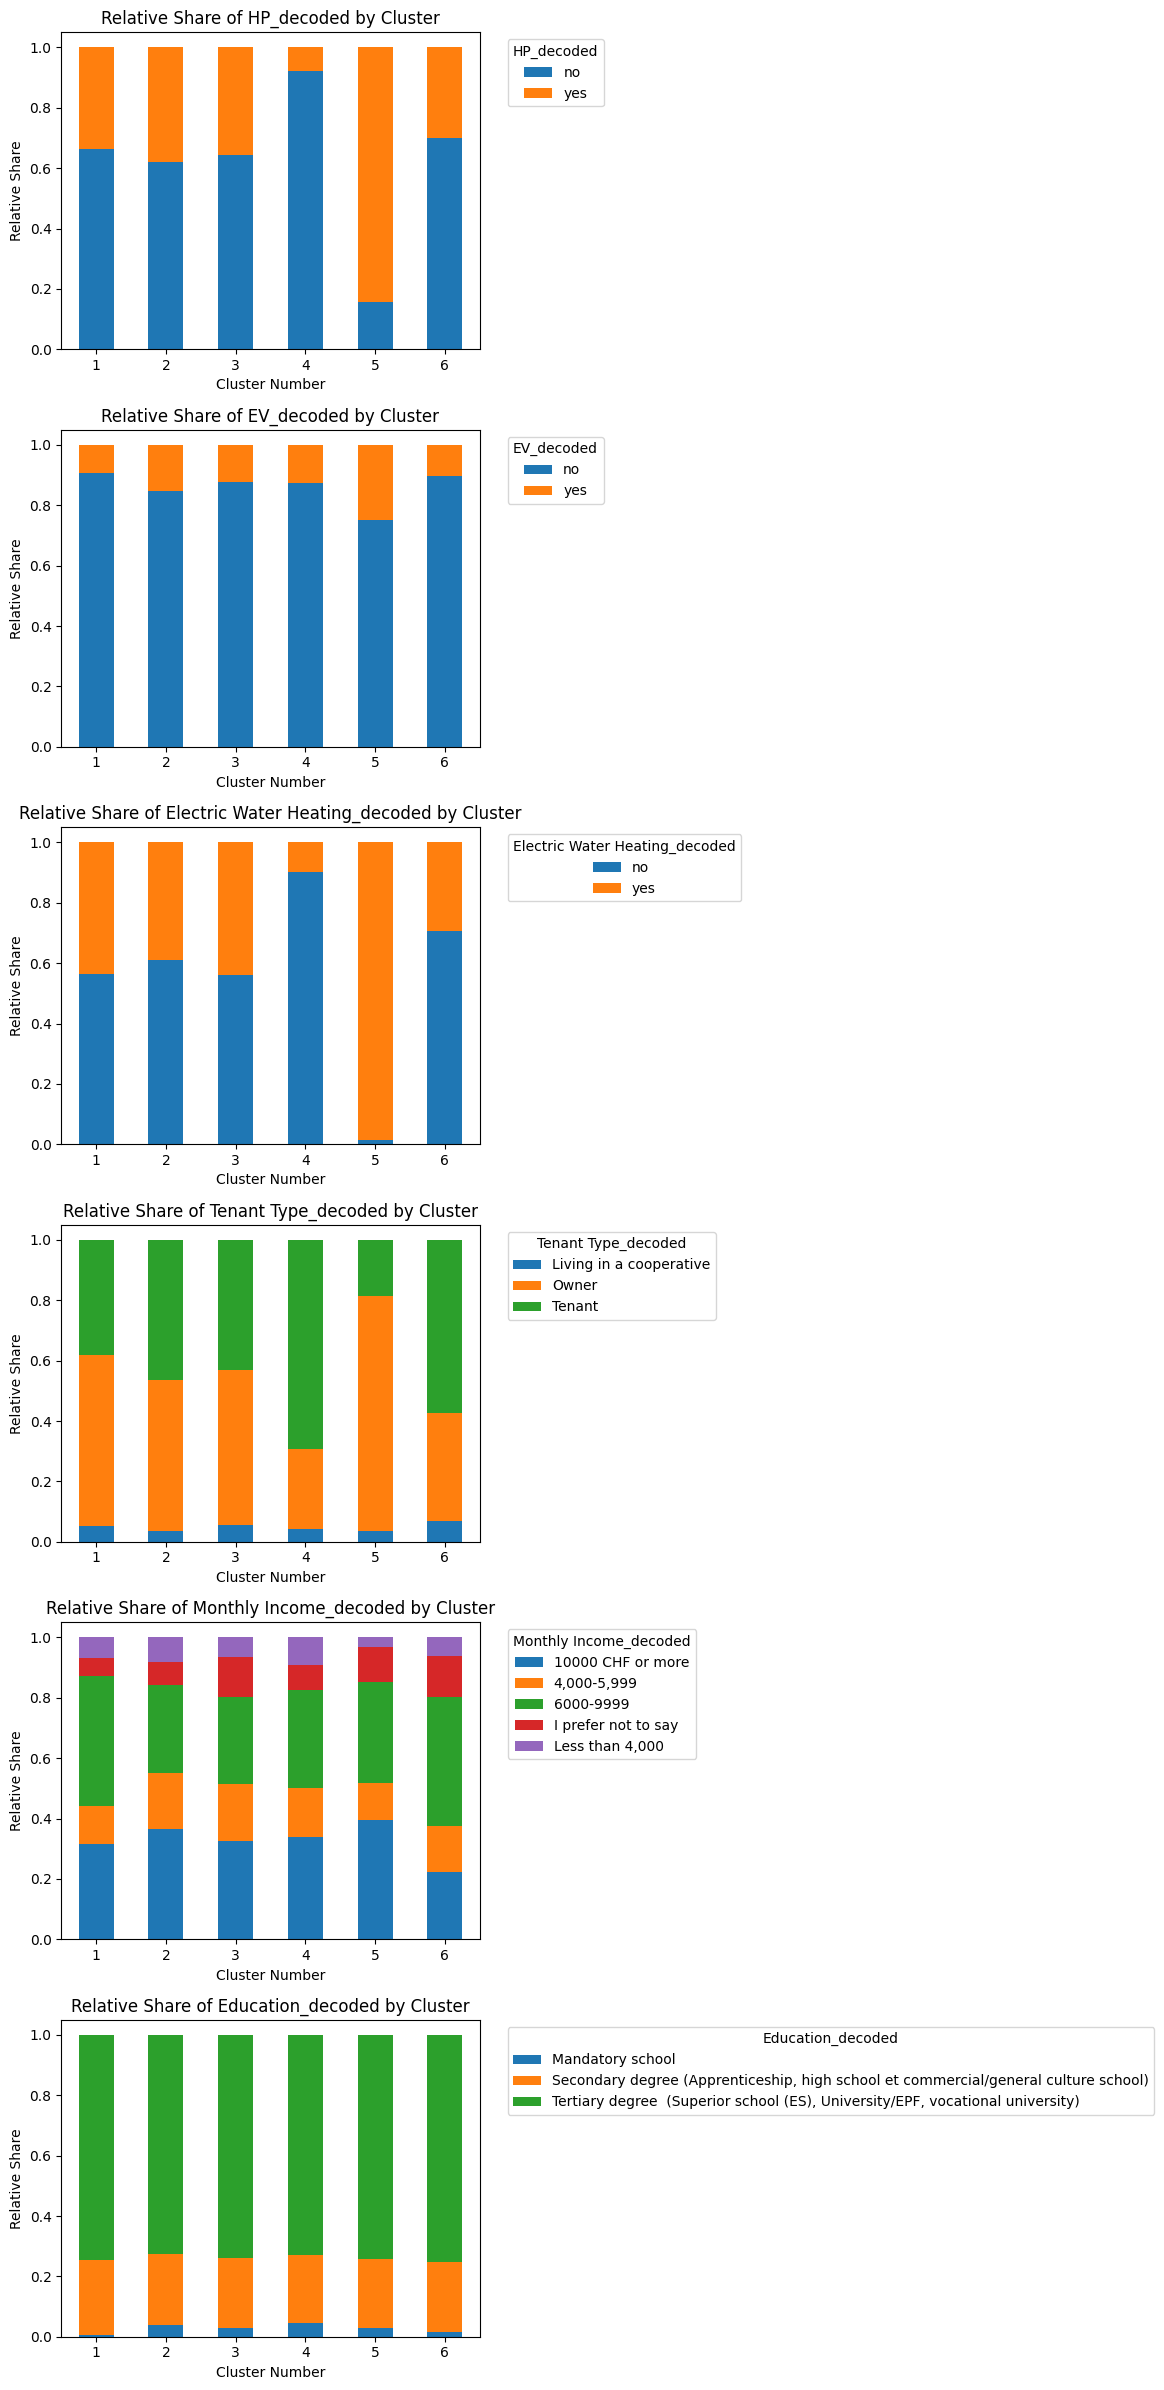

In [20]:
cat_columns = ['HP_decoded', 'EV_decoded', 'Electric Water Heating_decoded', 'Tenant Type_decoded', 'Monthly Income_decoded', 'Education_decoded']
n_features = len(cat_columns)

fig, axes = plt.subplots(n_features, 1, figsize=(12, 4 * n_features))

for i, feature in enumerate(cat_columns):
    ax = axes[i]
    
    # Group and pivot data for proportions
    counts = df_cleaned.groupby(['cluster', feature]).size().unstack(fill_value=0)
    proportions = counts.div(counts.sum(axis=1), axis=0)  # Normalize to get share per cluster
    
    # Plot stacked bar chart with proportions
    proportions.plot(kind='bar', stacked=True, ax=ax)
    
    # Titles and axis labels
    ax.set_title(f'Relative Share of {feature} by Cluster')
    ax.set_ylabel('Relative Share')
    ax.set_xlabel('Cluster Number')
    
    # Rotate x-axis tick labels
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.legend(title=feature, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [86]:
features = ['HP_decoded', 'EV_decoded', 'Electric Water Heating_decoded', 'Tenant Type_decoded', 'Monthly Income_decoded']
dfs = []

for feature in features:
    counts = df_cleaned.groupby(['cluster', feature]).size().unstack(fill_value=0)

    fractions = counts.div(counts.sum(axis=1), axis=0)
    
    # Rename cluster index to string with 'Cluster ' prefix
    fractions.index = [f'Cluster {c}' for c in fractions.index]
    
    # Use MultiIndex for rows: (feature, category)
    row_idx = pd.MultiIndex.from_product([[feature], fractions.columns], names=['Feature', 'Category'])
    
    # Transpose to have clusters as columns
    fractions = fractions.T
    
    # Assign MultiIndex rows
    fractions.index = row_idx
    
    dfs.append(fractions)

final_table = pd.concat(dfs)

#print(final_table)
display(final_table.style.format("{:.2%}"))





In [87]:
cluster_nums = [int(col.split()[1]) for col in final_table.columns]

# Calculate counts of samples per cluster from your cleaned df (df_cleaned)
cluster_counts = df_cleaned['cluster'].value_counts().sort_index()

# Extract counts matching the cluster numbers (fill with 0 if cluster missing)
counts_for_clusters = [cluster_counts.get(c, 0) for c in cluster_nums]

# Create DataFrame row with counts, row index MultiIndex
new_row = pd.DataFrame(
    [counts_for_clusters],
    columns=final_table.columns,
    index=pd.MultiIndex.from_tuples([('Number of Households', '')], names=final_table.index.names)
)

# Append new row at bottom
final_table_with_counts = pd.concat([final_table, new_row])

# Display with formatting
display(final_table_with_counts.style.format("{:.2%}"))

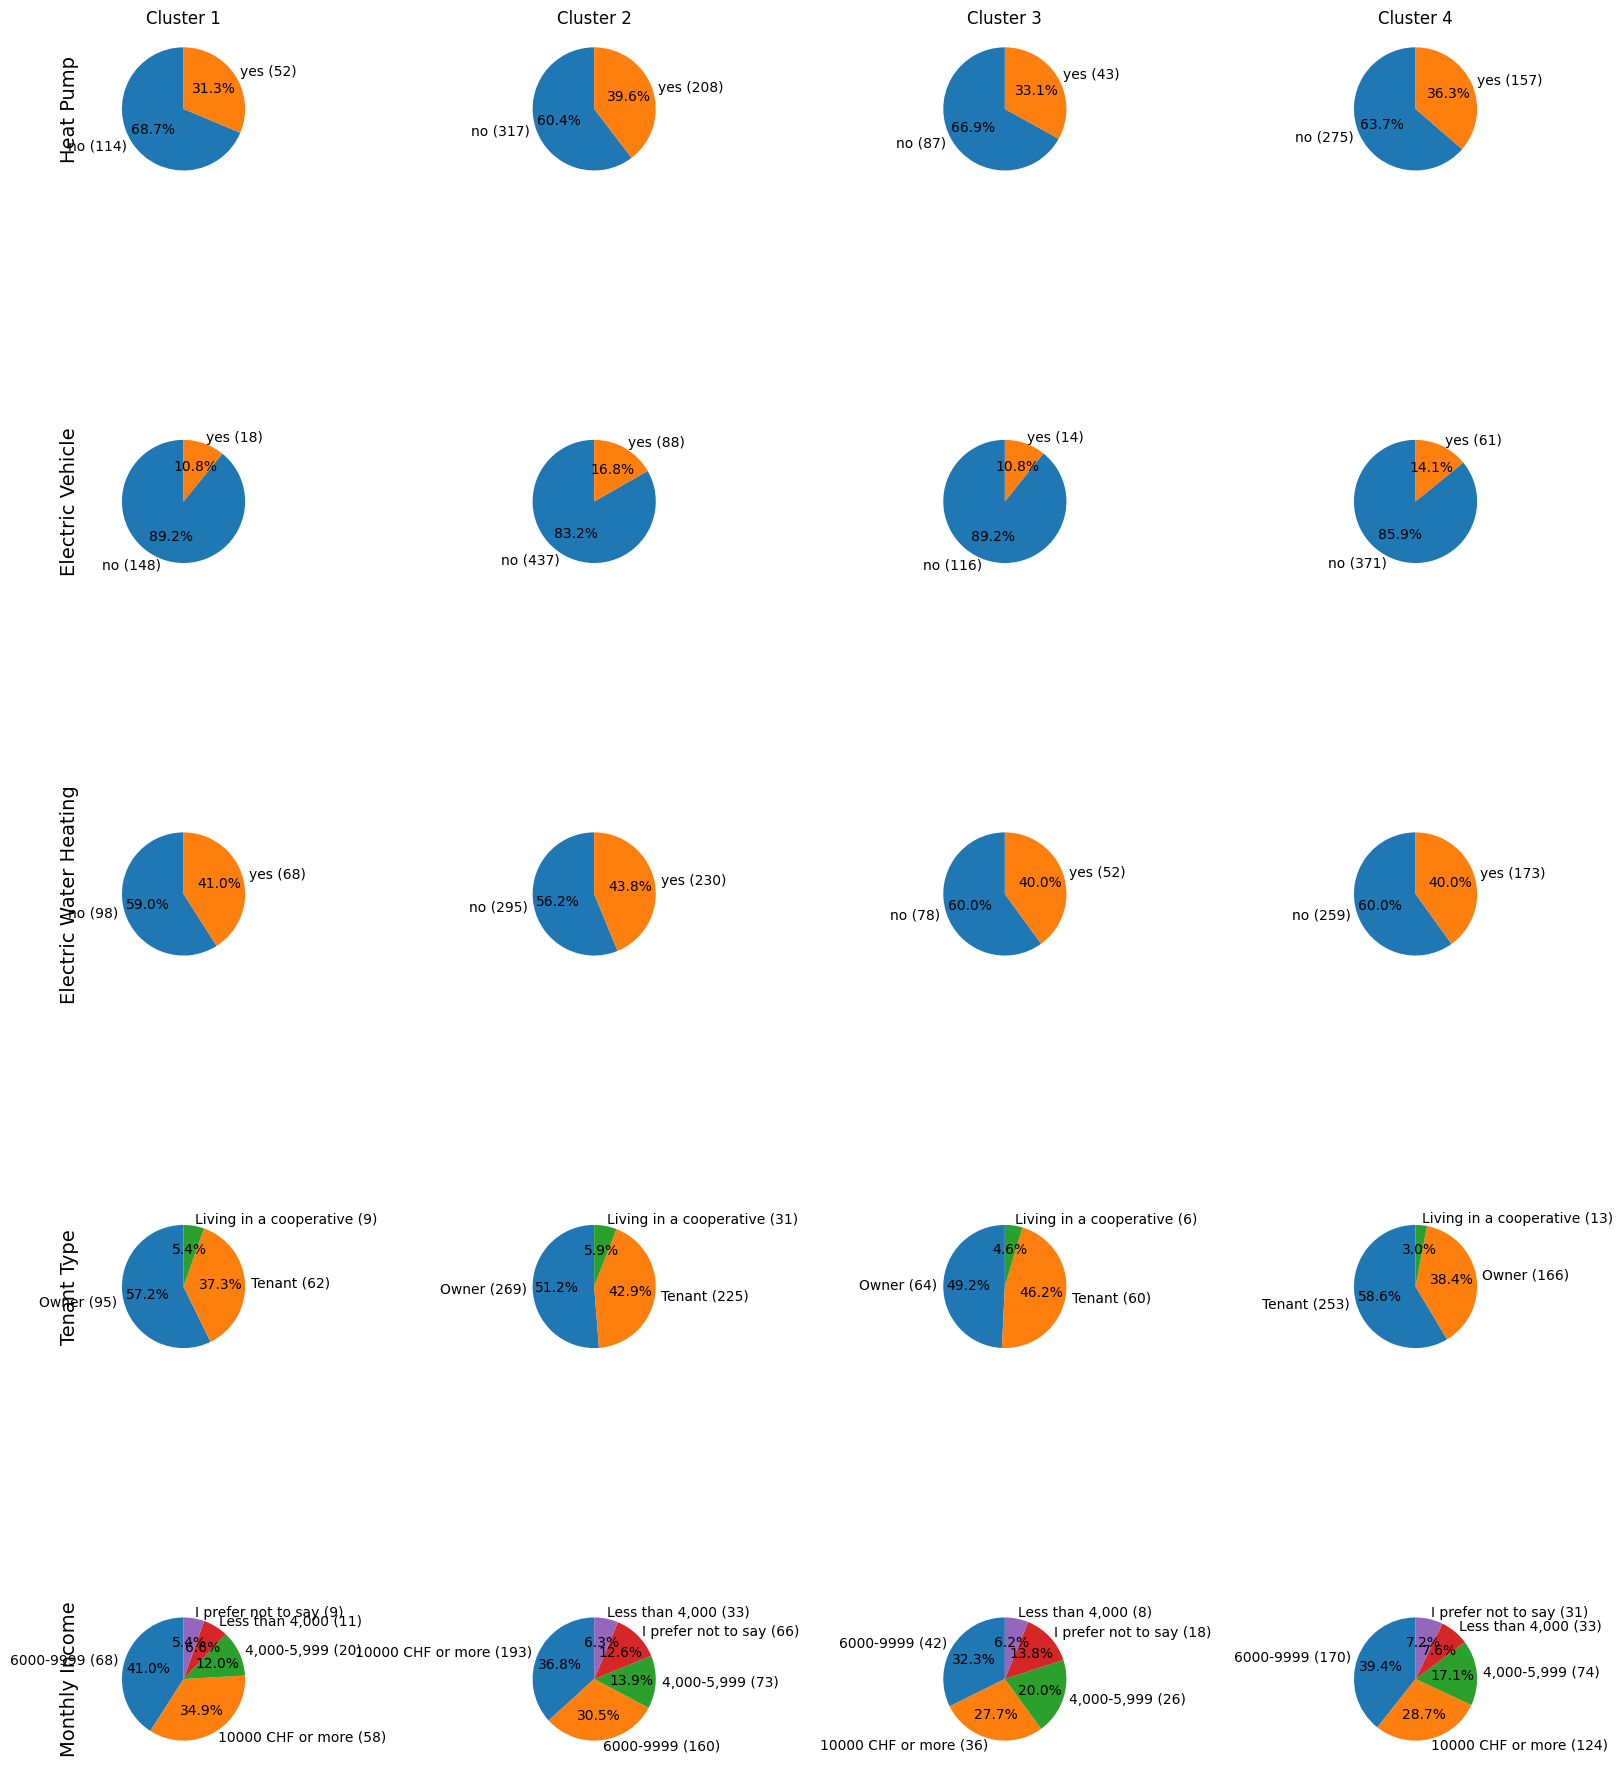

In [88]:
features = ['HP_decoded', 'EV_decoded', 'Electric Water Heating_decoded', 'Tenant Type_decoded', 'Monthly Income_decoded']

feature_label = ['Heat Pump', 'Electric Vehicle', 'Electric Water Heating', 'Tenant Type', 'Monthly Income']

# Get list of unique clusters sorted
clusters_sorted = sorted(df_cleaned['cluster'].unique())

n_features = len(features)
n_clusters = len(clusters_sorted)

fig, axes = plt.subplots(n_features, n_clusters, figsize=(4*n_clusters, 4*n_features))

for i, feature in enumerate(features):
    for j, cluster in enumerate(clusters_sorted):

        ax = axes[i, j] if n_features > 1 else axes[j]

        data = df_cleaned[(df_cleaned['cluster'] == cluster) & (df_cleaned[feature].notna())][feature]

        counts = data.value_counts()
        
        # Create labels including category name and count
        labels = [f"{cat} ({count})" for cat, count in zip(counts.index, counts.values)]
        
        ax.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90)
        
        if i == 0:
            ax.set_title(f'Cluster {cluster}')
        if j == 0:
            ax.set_ylabel(feature_label[i], fontsize=14, labelpad=20)

plt.tight_layout()
plt.show()